In [16]:
import numpy as np
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
from sklearn.feature_selection import RFE, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, auc, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


In [17]:
path = kagglehub.dataset_download("uciml/iris")
print(path)
dataset = pd.read_csv(path + "/Iris.csv")
dataset.info()

/home/dom/.cache/kagglehub/datasets/uciml/iris/versions/2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


array([[<Axes: xlabel='SepalLengthCm', ylabel='SepalLengthCm'>,
        <Axes: xlabel='SepalWidthCm', ylabel='SepalLengthCm'>,
        <Axes: xlabel='PetalLengthCm', ylabel='SepalLengthCm'>,
        <Axes: xlabel='PetalWidthCm', ylabel='SepalLengthCm'>],
       [<Axes: xlabel='SepalLengthCm', ylabel='SepalWidthCm'>,
        <Axes: xlabel='SepalWidthCm', ylabel='SepalWidthCm'>,
        <Axes: xlabel='PetalLengthCm', ylabel='SepalWidthCm'>,
        <Axes: xlabel='PetalWidthCm', ylabel='SepalWidthCm'>],
       [<Axes: xlabel='SepalLengthCm', ylabel='PetalLengthCm'>,
        <Axes: xlabel='SepalWidthCm', ylabel='PetalLengthCm'>,
        <Axes: xlabel='PetalLengthCm', ylabel='PetalLengthCm'>,
        <Axes: xlabel='PetalWidthCm', ylabel='PetalLengthCm'>],
       [<Axes: xlabel='SepalLengthCm', ylabel='PetalWidthCm'>,
        <Axes: xlabel='SepalWidthCm', ylabel='PetalWidthCm'>,
        <Axes: xlabel='PetalLengthCm', ylabel='PetalWidthCm'>,
        <Axes: xlabel='PetalWidthCm', ylabel='Petal

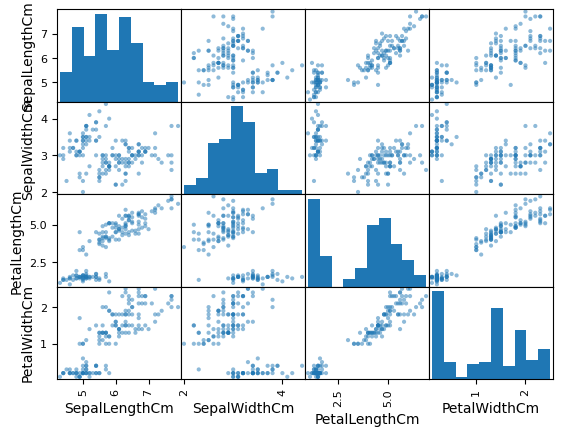

In [18]:
pd.plotting.scatter_matrix(dataset[dataset.columns.drop("Id")])

(array([50.,  0.,  0.,  0.,  0., 50.,  0.,  0.,  0., 50.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

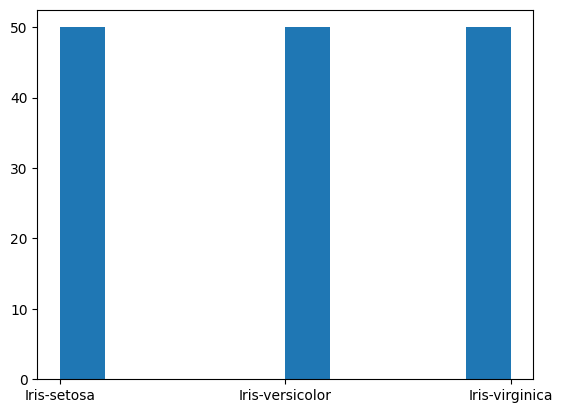

In [19]:
plt.hist(dataset["Species"])

In [20]:
class RobustMinMaxScaler:
    def __init__(self, qa: float, qb: float):
        self.q_r = [qa, qb]

    def fit(self, X, y=None):
        [self.qas, self.qbs] = np.quantile(X, self.q_r, axis=0)
        return self

    def transform(self, X):
        scaledX = (X - self.qas) / (self.qbs - self.qas)
        return scaledX

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [31]:
X = dataset[dataset.columns.drop("Species")]
y = dataset["Species"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120, 5), (30, 5), (120,), (30,))

In [22]:
def create_model_using_params(params: dict) -> object:
    n_features_to_select = params["n_features_to_select"]
    scaler_name = params["scaler_name"]
    model_name = params["model_name"]

    model_param_names = {
        "KNN": ["n_neighbors"],
        "LR": ["solver"],
    }[model_name]
    model_params = {p: params[p] for p in model_param_names}

    scaler = {
        "RobustMinMaxScaler": RobustMinMaxScaler(0.25, 0.75),
        "MinMaxScaler": MinMaxScaler(),
        "StandardScaler": StandardScaler(),
        "RobustScaler": RobustScaler(),
    }[scaler_name]

    Model = {
        "KNN": KNeighborsClassifier,
        "LR": LogisticRegression,
    }[model_name]

    model = Pipeline([
        ("scaler", scaler),
        ("selector", RFE(DecisionTreeClassifier(), n_features_to_select=n_features_to_select)),
        ("model", Model(**model_params)),
    ])
    return model

In [23]:
def objective_final(trial):
    params = dict(
        model_name = trial.suggest_categorical("model_name", ["KNN", "LR"]),

        scaler_name = trial.suggest_categorical("scaler_name", [
            "RobustMinMaxScaler",
            "MinMaxScaler",
            "StandardScaler",
            "RobustScaler",
        ]),

        n_features_to_select = trial.suggest_int("n_features_to_select", 1, X.shape[1]),

        n_neighbors = trial.suggest_int("n_neighbors", 1, 15),

        solver = trial.suggest_categorical("solver", ["lbfgs", "liblinear"])
    )

    model = create_model_using_params(params)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, scoring="roc_auc_ovr", cv=cv, n_jobs=-1).mean()
    return score

In [24]:
final_study = optuna.create_study(study_name="FinalStudy", direction='maximize', sampler=optuna.samplers.RandomSampler(42))
final_study.optimize(objective_final, n_trials=100)

[I 2025-12-09 11:11:43,326] A new study created in memory with name: FinalStudy
[I 2025-12-09 11:11:43,410] Trial 0 finished with value: 0.9882178681657848 and parameters: {'model_name': 'LR', 'scaler_name': 'RobustMinMaxScaler', 'n_features_to_select': 1, 'n_neighbors': 13, 'solver': 'liblinear'}. Best is trial 0 with value: 0.9882178681657848.
[I 2025-12-09 11:11:43,494] Trial 1 finished with value: 1.0 and parameters: {'model_name': 'LR', 'scaler_name': 'RobustMinMaxScaler', 'n_features_to_select': 2, 'n_neighbors': 8, 'solver': 'lbfgs'}. Best is trial 1 with value: 1.0.
[I 2025-12-09 11:11:43,557] Trial 2 finished with value: 0.9700694444444444 and parameters: {'model_name': 'KNN', 'scaler_name': 'RobustScaler', 'n_features_to_select': 1, 'n_neighbors': 8, 'solver': 'lbfgs'}. Best is trial 1 with value: 1.0.
[I 2025-12-09 11:11:43,610] Trial 3 finished with value: 0.994212962962963 and parameters: {'model_name': 'KNN', 'scaler_name': 'StandardScaler', 'n_features_to_select': 2, 'n_

In [25]:
final_study.best_params

{'model_name': 'LR',
 'scaler_name': 'RobustMinMaxScaler',
 'n_features_to_select': 2,
 'n_neighbors': 8,
 'solver': 'lbfgs'}

In [26]:
best_model = create_model_using_params(final_study.best_params)
best_model.fit(X_train, y_train)
best_model.score(X_test, y_test)

1.0

In [27]:

pred = best_model.predict(X_test)
pred

array(['Iris-versicolor', 'Iris-setosa', 'Iris-virginica',
       'Iris-versicolor', 'Iris-versicolor', 'Iris-setosa',
       'Iris-versicolor', 'Iris-virginica', 'Iris-versicolor',
       'Iris-versicolor', 'Iris-virginica', 'Iris-setosa', 'Iris-setosa',
       'Iris-setosa', 'Iris-setosa', 'Iris-versicolor', 'Iris-virginica',
       'Iris-versicolor', 'Iris-versicolor', 'Iris-virginica',
       'Iris-setosa', 'Iris-virginica', 'Iris-setosa', 'Iris-virginica',
       'Iris-virginica', 'Iris-virginica', 'Iris-virginica',
       'Iris-virginica', 'Iris-setosa', 'Iris-setosa'], dtype=object)

In [28]:
probs = best_model.predict_proba(X_test)
probs

array([[1.44932559e-01, 7.52546850e-01, 1.02520592e-01],
       [8.94877369e-01, 1.04883519e-01, 2.39111843e-04],
       [4.75792479e-04, 1.31543133e-01, 8.67981075e-01],
       [5.97236377e-02, 7.39118558e-01, 2.01157805e-01],
       [8.24873554e-02, 7.56713738e-01, 1.60798907e-01],
       [8.19562543e-01, 1.79525348e-01, 9.12108789e-04],
       [1.52367235e-01, 7.70382568e-01, 7.72501972e-02],
       [8.31139010e-05, 4.54305006e-02, 9.54486385e-01],
       [8.53597222e-02, 7.85443748e-01, 1.29196530e-01],
       [1.08310794e-01, 7.34301653e-01, 1.57387553e-01],
       [2.44785776e-03, 2.59791408e-01, 7.37760734e-01],
       [9.42709994e-01, 5.72181025e-02, 7.19030431e-05],
       [8.63615983e-01, 1.35722640e-01, 6.61376659e-04],
       [9.47335679e-01, 5.26074809e-02, 5.68401507e-05],
       [8.92045380e-01, 1.07696416e-01, 2.58204488e-04],
       [9.94907365e-02, 8.15605774e-01, 8.49034891e-02],
       [1.82172724e-03, 2.61615476e-01, 7.36562797e-01],
       [2.00950981e-01, 7.28941

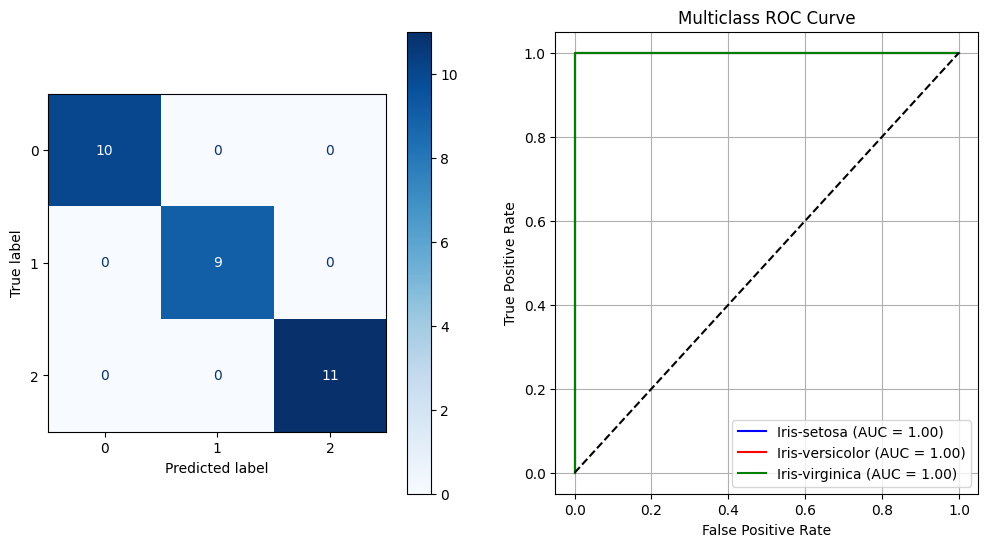

In [29]:
from sklearn.metrics import confusion_matrix


axs = plt.subplots(1, 2, figsize=(12, 6))[1].flatten()

pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", ax=axs[0])
plt.grid(False)
axs[0].grid(False)


probs = best_model.predict_proba(X_test)
# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

temp_y_bin = label_binarize(y_test, classes=best_model.classes_)

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(temp_y_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

ax = axs[1]
colors = np.array(['blue', 'red', 'green'])
for i, color in zip(range(3), colors):
    label = f'{best_model.classes_[i]} (AUC = {roc_auc[i]:.2f})'
    ax.plot(fpr[i], tpr[i], color=color, label=label)

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Multiclass ROC Curve')
ax.legend(loc='lower right')
ax.grid(True)



In [30]:
temp_y_bin = label_binarize(y_train, classes=best_model.classes_)

for a,b in zip(temp_y_bin,probs):
    print(a,b)

[1 0 0] [0.14493256 0.75254685 0.10252059]
[1 0 0] [8.94877369e-01 1.04883519e-01 2.39111843e-04]
[0 1 0] [4.75792479e-04 1.31543133e-01 8.67981075e-01]
[1 0 0] [0.05972364 0.73911856 0.2011578 ]
[1 0 0] [0.08248736 0.75671374 0.16079891]
[0 0 1] [0.81956254 0.17952535 0.00091211]
[0 1 0] [0.15236723 0.77038257 0.0772502 ]
[1 0 0] [8.31139010e-05 4.54305006e-02 9.54486385e-01]
[1 0 0] [0.08535972 0.78544375 0.12919653]
[1 0 0] [0.10831079 0.73430165 0.15738755]
[0 0 1] [0.00244786 0.25979141 0.73776073]
[0 1 0] [9.42709994e-01 5.72181025e-02 7.19030431e-05]
[0 1 0] [8.63615983e-01 1.35722640e-01 6.61376659e-04]
[1 0 0] [9.47335679e-01 5.26074809e-02 5.68401507e-05]
[1 0 0] [8.92045380e-01 1.07696416e-01 2.58204488e-04]
[0 1 0] [0.09949074 0.81560577 0.08490349]
[0 0 1] [0.00182173 0.26161548 0.7365628 ]
[0 0 1] [0.20095098 0.72894195 0.07010707]
[0 1 0] [0.195343   0.75644531 0.04821169]
[0 0 1] [2.42298116e-04 7.97822436e-02 9.19975458e-01]
[0 1 0] [8.86406001e-01 1.13206219e-01 3.877